<a href="https://colab.research.google.com/github/dtuleva/Images_and_Convolutions/blob/main/Images_and_Convolutions_part_2_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib.colors import TwoSlopeNorm
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from scipy.ndimage import convolve
from skimage.io import imread

# Images and Convolutions
### The simple, complex and convoluted notions behind computer vision
## Part 2 - Convolutional Neural Networks

#### Helper functions

In [2]:
def plot_image_subplots(
        images,
        titles=None,
        subplot_kwargs=None,
        nrows=1,
        ncols=3,
        figsize_hor=12,
        figsize_ver=6,
        no_ticks=True
    ):
    """
    Plots a grid of images with titles, allowing for different keyword arguments for each subplot.

    Example usage:
    plot_image_subplots(
        images=[image_1, image_2, image_3],
        titles=["Title 1", "Title 2", "Title 3"],
        plot_kwargs=[
            {"cmap": "gray"},
            {"cmap": "Reds_r", "vmin": 0, "vmax": 1},
            {"cmap": "Blues_r", "vmin": -1, "vmax": 1}
        ],
        nrows=1,
        ncols=3,
        figsize_hor=15,
        figsize_ver=5
    )
    """
    if titles is None:
        titles = ["" for _ in images]
    else:
        assert len(images) == len(titles), "Number of images not equal to number of titles"

    if subplot_kwargs is None:
        subplot_kwargs = [{} for _ in images]
    else:
        assert len(images) == len(subplot_kwargs), "Number of images not equal to number of plot_kwargs"

    for kwargs in subplot_kwargs:
        if "cmap" not in kwargs:
            kwargs["cmap"] = "gray"

    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize_hor, figsize_ver))
    axs = axs.flatten()

    for i, (image, title) in enumerate(zip(images, titles)):
        axs[i].imshow(image, **subplot_kwargs[i])
        axs[i].set_title(title)

    if no_ticks:
        plt.setp(axs, xticks=[], yticks=[])

    plt.tight_layout()
    plt.show()


In [3]:

def limit_range(pixel_value, min_value = 0, max_value = 1):
    """
    Function to keep the range of pixel values; (0, 1) by default
    """
    if pixel_value < min_value:
        pixel_value = min_value
    elif pixel_value > max_value:
        pixel_value = max_value
    return pixel_value

limit_range = np.vectorize(limit_range)

In [4]:
def convolve_3_channel_image(image, filter):
    """
    Applies scipy.ndimage.convolve(image_channel, filter) separately on each channel of the image and
    returns the resulting convolutions stacked to resemble a color image.
    """
    return np.dstack([convolve(image[:, :, i], filter) for i in range(3)])

In [5]:
def plot_convolutions(image, filters, titles = None, subplot_kwargs = None, single_channel = True, **plot_kwargs):
    """
    Plot images resulting from convolution with given filters.
    """
    if single_channel:
        conv_results = [convolve(image, filter) for filter in filters]
    else:
        conv_results = [convolve_3_channel_image(image, filter) for filter in filters]


    plot_image_subplots(conv_results, titles, subplot_kwargs, **plot_kwargs)

In [6]:
def convolve_color_image_with_3_filters(image, filter_triplet):
  """
    Applies the respective filter to each channel of an image and stacks the resulting convolutions
  """
  return np.dstack([convolve(image[:, :, i], filter_triplet[i]) for i in range(3)])


In [7]:
def plot_heatmaps(arrays, titles = None, nrows = 1, ncols = 2, figsize_hor = 12, figsize_ver = 3, cmap_limit = 0.1):
    """
    Plots a heatmap of each array with a common colorbar.
    Heatmaps are zero-centered, blue indicating negative values, red - positive.

    """
    if titles is None:
        titles = ["" for _ in arrays]
    else:
        assert len(arrays) == len(titles), "Number of arrays not equal to number of titles"

    # Create the figure and axes
    fig, axs = plt.subplots(nrows, ncols, figsize = (figsize_hor, figsize_ver), layout = "compressed")
    if len(arrays) > 1:
        axs = axs.flatten()
    else:
        axs = [axs]

    # Find the global min and max values across all data for common scaling
    global_min = min(data.min() for data in arrays)
    global_max = max(data.max() for data in arrays)

    global_abs = max([abs(global_min), global_max])

    # Create a common normalization
    norm = TwoSlopeNorm(vmin = - cmap_limit - global_abs, vmax = cmap_limit + global_abs, vcenter = 0)

    # Plot each data array
    for ax, array, title in zip(axs, arrays, titles):
        cax = ax.imshow(array, cmap = "seismic", norm = norm)
        ax.set_title(title)

    # Add a single colorbar
    cbar = fig.colorbar(cax, ax=axs[:len(arrays)])

    # Remove axis ticks
    plt.setp(axs, xticks=[], yticks=[])


    plt.show()


## Convolutional Neural Networks

Convolutional Neural Networks (CNNs) are deep learning models that are primarily used for analyzing visual data. They are practically the standard for tasks involving image and video recognition, and are used as base models for object detection and segmentation. The convolutional layers apply convolutional filters to the input image, detecting local patterns such as edges, textures, and simple shapes. The values of the elements of the convolutional filters are actually the parameters optimized by training the network, so all convolutional layers are effectively one big feature extractor. 

### Minimalist CNN

Our cat ir rather unfit for the purpose of demonstrating how convolutional neural networks work. That is we would need vastly greater number of cats to make it work. Further more, recognizing a cat is a hard task - there are a lot of other things with eyes, nose and fur, so we would need wide and deep neural network and a lot of images, time, knowledge and skill to train it (and we have neither of those). So we will take the simplest image dataset in existence - MNIST, which happens to be readily available in Tensorflow Datasets. It consists of small, one channel images of handwritten digits, annotated which digit it is supposed to be.
We load our dataset, normalize pixel values and add an extra dimension to the images, because expected shape for an image is (width, height, channels).

In [8]:
# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a channels dimension
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]


Let's take a look at our dataset:

In [9]:
train_images.shape

(60000, 28, 28, 1)

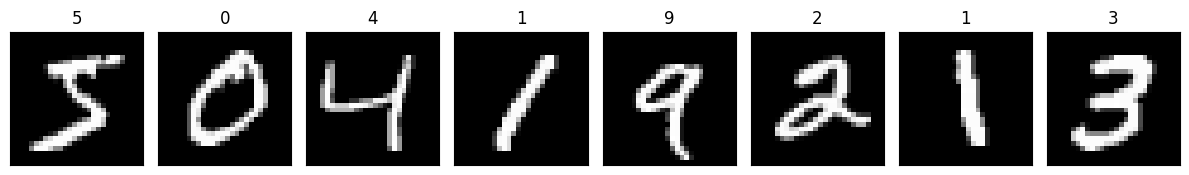

In [10]:
n_images = 8
plot_image_subplots(train_images[:n_images], titles=train_labels[:n_images], ncols = n_images, nrows = 1)

To make our task even more simple we make it a binary one - we will train a model to predict weather the digit is `8` or not. That means we need to convert our labels - 1 for "yes, this is an image of the digit eight" and 0 for "no, it is not an eight".

In [11]:
# Convert labels to binary: 1 for class '8', 0 for others
train_labels_bin = (train_labels == 8).astype(int)
test_labels_bin = (test_labels == 8).astype(int)

We define our convolutional model - as simple as possible - a sequential model with fixed input shape, convolutional layer with single kernel, layer for reshaping into 1d array and final dense layer with sigmoid activation. This essentially is logistic regression over the flattened convolution output - not even an actual neural network.

In [12]:
# Define the convolutional model
conv_model = Sequential([
    InputLayer((28, 28, 1)), # Input layer with the shape of our images
    Conv2D(1, (3, 3)), # Single convolutional layer with one 3 x 3 filter
    Flatten(),
    Dense(1, activation='sigmoid')  # Single output neuron for binary classification
])


In [13]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 1)         10        
                                                                 
 flatten (Flatten)           (None, 676)               0         
                                                                 
 dense (Dense)               (None, 1)                 677       
                                                                 
Total params: 687 (2.68 KB)
Trainable params: 687 (2.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We have 10 parameters in our convolutional layer - 3 x 3 - 9 values in the kernel and a bias term.

We compile the model with the basics, just add precision and recall since we turned our dataset in an unbalanced one - there are far less eights than other digits combined.

In [14]:
# Compile the model
conv_model.compile(optimizer="sgd",
              loss="binary_crossentropy",
              metrics=["accuracy", 'Precision', 'Recall']) # ffff, with CAPITAL letter, why ...

And train the model on the train images with binary labels for a single epoch:

In [15]:
# Train the model
conv_history = conv_model.fit(train_images, train_labels_bin, epochs=1)



1875/1875 [==============================] - 26s 12ms/step - loss: 0.2355 - accuracy: 0.9170 - precision: 0.7680 - recall: 0.2128


And evaluate the model on the test set:

In [16]:
# Evaluate the model
conv_results = conv_model.evaluate(test_images, test_labels_bin, verbose=2)

# Print the results
print(f"Test Accuracy: {conv_results[1]}")
print(f"Test Precision: {conv_results[2]}")
print(f"Test Recall: {conv_results[3]}")

313/313 - 2s - loss: 0.1534 - accuracy: 0.9469 - precision: 0.9064 - recall: 0.5072 - 2s/epoch - 5ms/step
Test Accuracy: 0.9469000101089478
Test Precision: 0.9064220190048218
Test Recall: 0.5071868300437927


Overall good results, though the recall is somewhat low. Let's split the test set into eights and not eights and see some of the predictions. Title is the probability resnet50 gives to the image for being an 8.

In [17]:
test_images_8 = test_images[test_labels == 8]
test_images_other = test_images[test_labels != 8]

In [18]:
n_images = 9

1/1 [==============================] - 0s 112ms/step


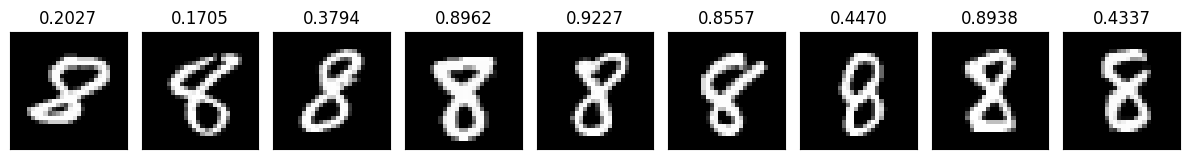

In [19]:
images_to_plot = test_images_8[:n_images]
predictions = conv_model.predict(images_to_plot)
titles = [f"{prob[0]:.4f}" for prob in predictions.tolist()]


plot_image_subplots(images_to_plot, titles=titles, ncols = n_images, nrows = 1, figsize_ver = 2)


1/1 [==============================] - 0s 25ms/step


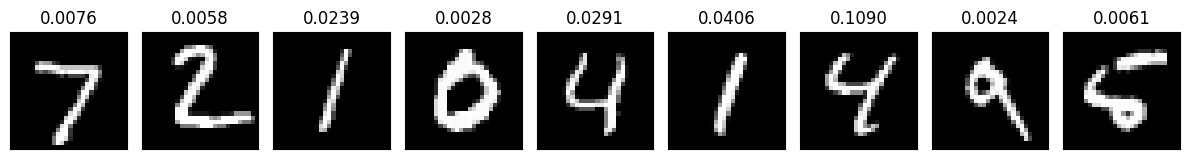

In [20]:
images_to_plot = test_images_other[:n_images]
predictions = conv_model.predict(images_to_plot)
titles = [f"{prob[0]:.4f}" for prob in predictions.tolist()]


plot_image_subplots(images_to_plot, titles=titles, ncols = n_images, nrows = 1, figsize_ver = 2)


Let's see our convolutional kernel, that helped distinguish 8 from not-8.

In [21]:
conv_layer = conv_model.layers[0]
kernel_weights, bias = conv_layer.get_weights()
kernel_weights.shape

(3, 3, 1, 1)

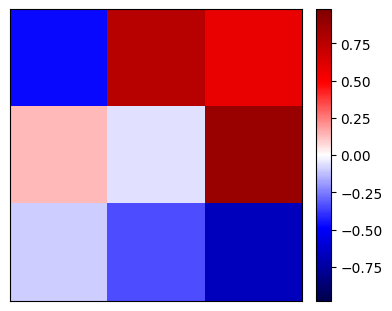

In [22]:
conv_filter = kernel_weights[:, :, 0, 0]
plot_heatmaps([conv_filter], ncols=1)

And let's see what this filter is actually doing by convolving it with few of the test images:

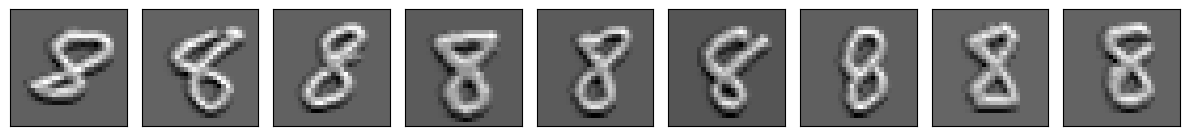

In [23]:
n_images = 9
images_to_plot = np.array([convolve(test_images_8[i][:, :, 0], conv_filter) for i in range(n_images)])

plot_image_subplots(images_to_plot, ncols = n_images, nrows = 1, figsize_ver = 2)

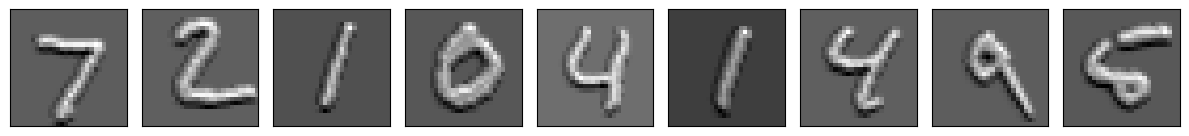

In [24]:
n_images = 9
images_to_plot = np.array([convolve(test_images_other[i][:, :, 0], conv_filter) for i in range(n_images)])

plot_image_subplots(images_to_plot, ncols = n_images, nrows = 1, figsize_ver = 2)

Cool, the digits now look like 3d - having really believable shaddow.

Actually our kernel is just 10 out of the almost 700 parameters, so it _helps_ classification, but does not do all the work. Aaand MNIST is really easy, even a simple logistic regression (no NNs involved) does the job. So we make a base model, the same like ours, but with no convolutional layer and compare results:

In [25]:
# Define the base model
base_model = Sequential([
    InputLayer((28, 28, 1)),
    # Conv2D(1, (3, 3)), # Skip the convolutional layer
    Flatten(),
    Dense(1, activation='sigmoid')
])


In [26]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 785       
                                                                 
Total params: 785 (3.07 KB)
Trainable params: 785 (3.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Compile the model
base_model.compile(optimizer="sgd",
              loss="binary_crossentropy",
              metrics=["accuracy", 'Precision', 'Recall'])

# Train the model
base_history = base_model.fit(train_images, train_labels_bin, epochs=1)

# Evaluate the model
base_results = base_model.evaluate(test_images, test_labels_bin, verbose=2)



1875/1875 [==============================] - 6s 3ms/step - loss: 0.2386 - accuracy: 0.9201 - precision: 0.7572 - recall: 0.2654
313/313 - 1s - loss: 0.1926 - accuracy: 0.9320 - precision: 0.7784 - recall: 0.4220 - 1s/epoch - 4ms/step


In [28]:
conv_train = {el[0]: el[1][0] for el in conv_history.history.items()}
base_train = {el[0]: el[1][0] for el in base_history.history.items()}
eval_keys = list(conv_train.keys())

In [29]:
conv_test = {eval_keys[i]: conv_results[i] for i in range(4)}
base_test = {eval_keys[i]: base_results[i] for i in range(4)}

In [30]:
pd.DataFrame.from_records([conv_train, conv_test, base_train, base_test], index = ["Conv Model Train", "Conv Model Test", "Base Model Train", "Base Model Test"])



loss  accuracy  precision    recall
Conv Model Train  0.235517  0.916967   0.768044  0.212784
Conv Model Test   0.153432  0.946900   0.906422  0.507187
Base Model Train  0.238553  0.920067   0.757192  0.265425
Base Model Test   0.192629  0.932000   0.778409  0.421971

Best description for our results is __insignifficant differences__. But no one makes NN with single convolutional kernel. The convolutional layer is in it's essence feature extraction. And for working neural network, we need a lot of features. So let's explore a real and pretrained CNN - Resnet 50.

### Resnet50

We load Resnet50 from Tensorflow Keras Applications - the architecture and the weights. Resnet50 is a deep convolutional neural network with 50 layers, using residual connections to mitigate the vanishing gradient problem. Model is trained on ImageNet - large dataset of images in 1000 classes - various types of everyday items, people,vehicles, animals, plants and what not.

In [31]:
resnet = ResNet50(include_top = True, weights = "imagenet", classifier_activation = "softmax")

In [32]:
# We skip the summary as it is 50 miles long
# resnet.summary()

And we read our cat again, but as tensor, directly with TensorFlow. As reading it from URL proved to be too complicated and of no value to our work, we downloaded it ar read it from file path.

In [33]:
cat_image_path = "/content/140272627-grooming-needs-senior-cat-632x475.jpg"
cat_image = tf.io.decode_jpeg(tf.io.read_file(cat_image_path))
cat_image.shape

TensorShape([475, 632, 3])

And make a 3 channel gray cat:

In [34]:
cat_one_ch = cat_image.numpy().mean(axis=2).astype(int) # need int for matplotlib
cat_gray = np.dstack([cat_one_ch, cat_one_ch, cat_one_ch])
cat_gray.shape

(475, 632, 3)

The pretrained Resnet50 expects defined size and preprocessing for the input:

In [35]:
def preprocess_image(img, image_size = (224, 224)):
    img = tf.image.resize(img, image_size)
    img = preprocess_input(img) # tensorflow.keras.applications.resnet50.preprocess_input
    # The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

    return img

In [36]:
ginger = preprocess_image(cat_image)
cat = preprocess_image(cat_gray)
ginger.shape, cat.shape

(TensorShape([224, 224, 3]), TensorShape([224, 224, 3]))

Now our cats are in shape for predicting, just let's see what exactly have we read and preprocessed:

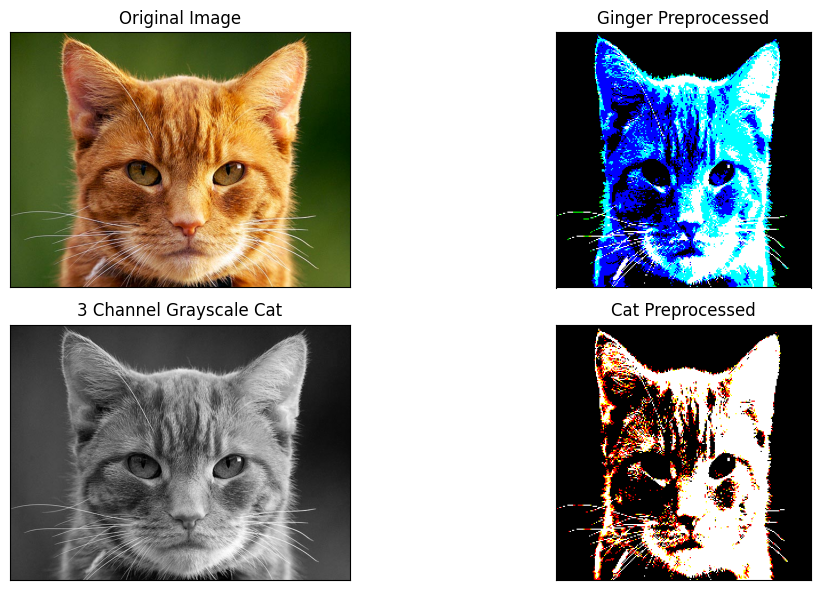

In [37]:
plot_image_subplots([cat_image, ginger, cat_gray, cat], titles=["Original Image", "Ginger Preprocessed", "3 Channel Grayscale Cat", "Cat Preprocessed"], ncols = 2, nrows = 2)

In [38]:
ginger_input = tf.expand_dims(ginger, axis=0)
cat_input = tf.expand_dims(cat, axis=0)
ginger_input.shape, cat_input.shape

(TensorShape([1, 224, 224, 3]), TensorShape([1, 224, 224, 3]))

And let's predict on our cat images, and decode the predictions to match the index to the class code and name. The numbers at the back are the probabilities.

In [39]:
decode_predictions(resnet.predict(ginger_input), top = 10)

1/1 [==============================] - 2s 2s/step


[[('n02123159', 'tiger_cat', 0.7707802),
  ('n02123045', 'tabby', 0.19302115),
  ('n02124075', 'Egyptian_cat', 0.03149193),
  ('n02127052', 'lynx', 0.0011865066),
  ('n03958227', 'plastic_bag', 0.00079650467),
  ('n02971356', 'carton', 0.00070170657),
  ('n02123597', 'Siamese_cat', 0.00022084033),
  ('n04589890', 'window_screen', 0.00018029395),
  ('n02123394', 'Persian_cat', 0.00012357364),
  ('n02909870', 'bucket', 0.00012081977)]]

In [40]:
decode_predictions(resnet.predict(cat_input), top = 10)

1/1 [==============================] - 0s 220ms/step


[[('n02123159', 'tiger_cat', 0.5471825),
  ('n02123045', 'tabby', 0.33567598),
  ('n02124075', 'Egyptian_cat', 0.11226764),
  ('n02127052', 'lynx', 0.0025763176),
  ('n02971356', 'carton', 0.0007310831),
  ('n02123597', 'Siamese_cat', 0.00042916395),
  ('n03958227', 'plastic_bag', 0.00026486436),
  ('n04589890', 'window_screen', 0.0002060607),
  ('n02909870', 'bucket', 7.573915e-05),
  ('n03657121', 'lens_cap', 7.26197e-05)]]

Our model is very sure the image is a cat, especially the color one. Which is no surprise, since the model is trained on color images only. Our ginger has very high probability for being a not only a cat, but a tiger cat - 0.77, large difference between the first two probabilities - from 0.77 to 0.19, and first few classes all make sense for our image - tabby, Egyptian cat, lynx ar all cats with stripes, that can be orange. All these are indicating that resnet50 knows exactly what our image is, and that our pipeline is not faulty (why is `tf.io.decode_jpeg` not equal to `tf.image.decode_jpeg`? Need to find that out some other time.)
If something is not ok with reading, decoding and processing the image the predictions are quite strange - top prediction of a cat can be pillow (ask me how I know that), common classes for "something went south" are nematode (a worm for all things squiggly), toilet tissue (plain texture) or tench (a type of fish that happens to be class 0).

Now that we know that our Resnet50 is working properly, we can visualize the kernels in the first convolutional layer.

In [41]:
for layer in resnet.layers[:5]:
  print(layer)

In [42]:
first_conv = resnet.layers[2]
first_conv.name, first_conv

('conv1_conv',
 <keras.src.layers.convolutional.conv2d.Conv2D at 0x7ac58bf90b20>)

In [43]:
kernel_conv1, bias_conv_1 = first_conv.weights
kernel_conv1.shape, bias_conv_1.shape

(TensorShape([7, 7, 3, 64]), TensorShape([64]))

In [44]:
kernel_conv1.numpy().min(), kernel_conv1.numpy().max()

(-0.6710244, 0.70432377)

And here is the histogram of the weights:

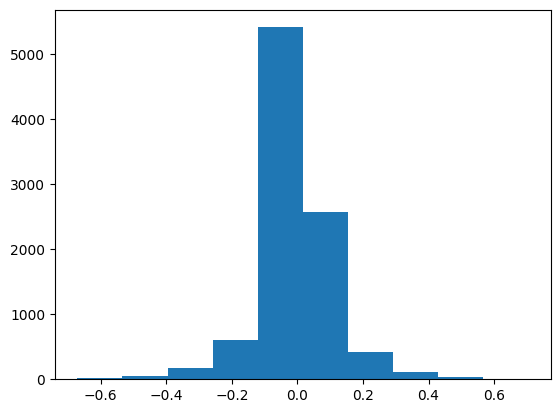

In [45]:
weights_kernel_flat = kernel_conv1.numpy().flatten()
plt.hist(weights_kernel_flat)
plt.show()

In [46]:
# kernels = kernel_conv1[:,:, :3, :10].numpy()
# swapping axes and reshaping and flattening is hard, soo..
kernels = []

for unit in range(20):
  for channel in range(3):
    kernels.append(kernel_conv1[:,:, channel, unit].numpy())

In [47]:
len(kernels), kernels[0].shape

(60, (7, 7))

We plot the first few kernels:

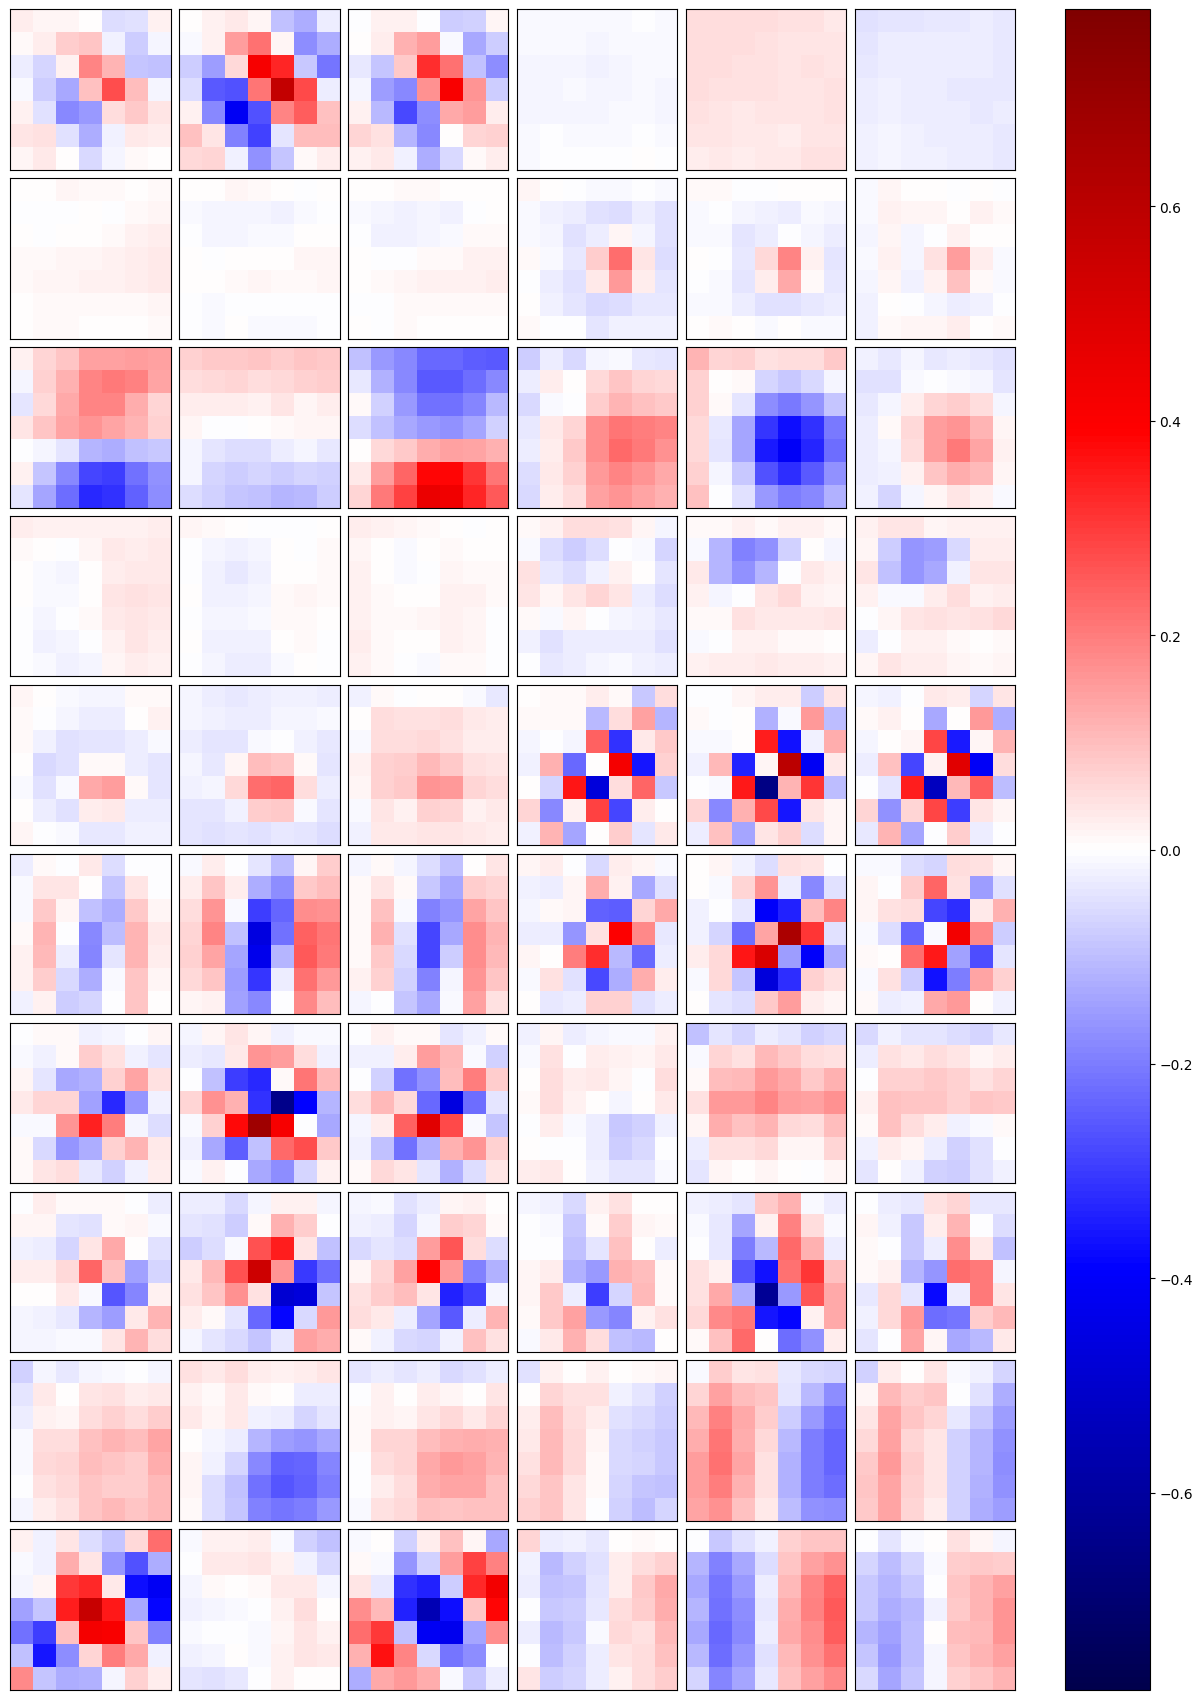

In [48]:
plot_heatmaps(kernels, nrows = 10, ncols = 6, figsize_ver = 20)

Interesting thing we observe is that the kernels come in threes - the kernel for the red, green and blue channel in each unit have similar patterns, although they are randomly initialized and optimized independently. Some look similar to mean filters (single shade), edge detectors (lines in blue on one side, white in the middle and red on the other side), others we cannot make any sense of. To try to explain to humans what features resnet is extracting, we plot the convolutions of said kernels with our cat.

First we take one kernel per unit and convolve it with a one-channel grayscale cat:

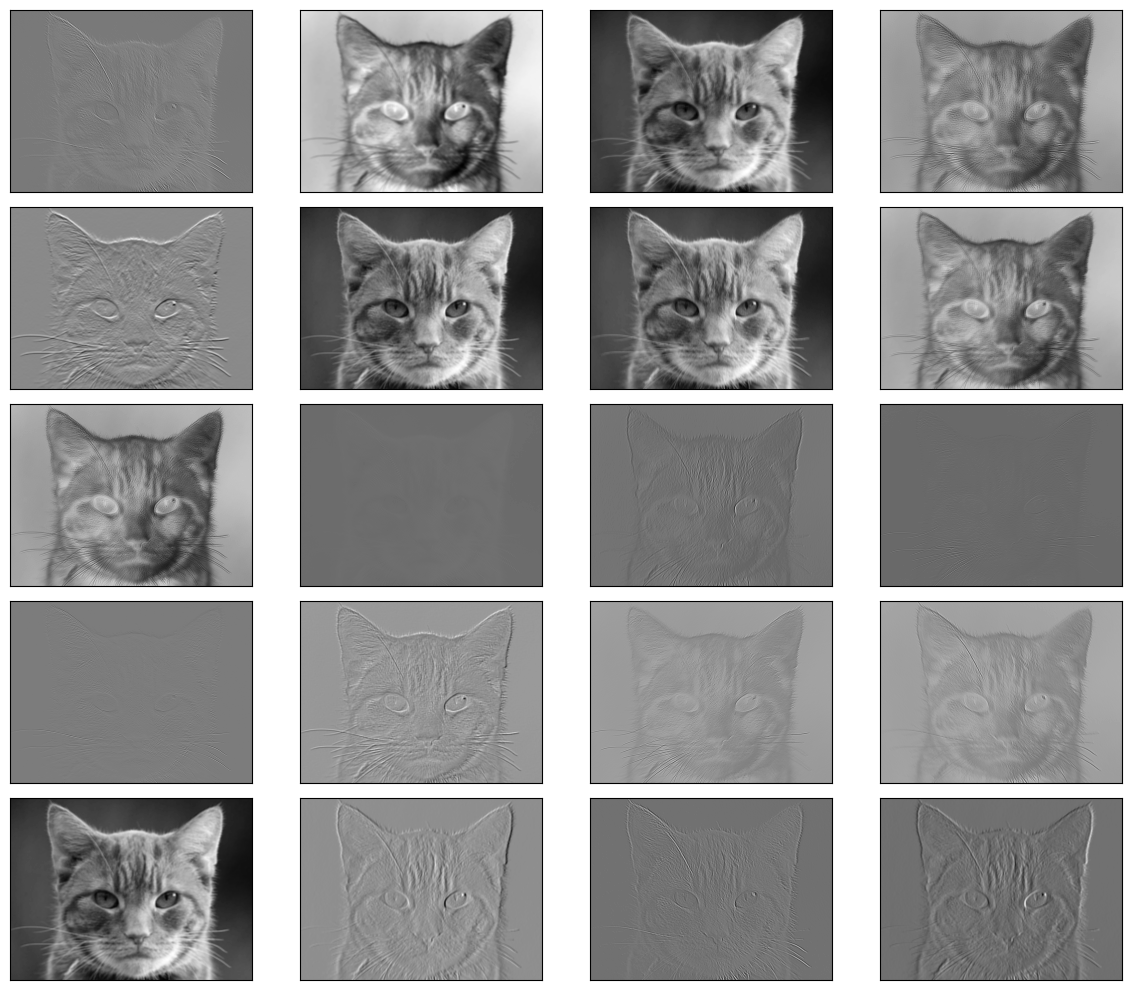

In [49]:
plot_convolutions(cat_one_ch, kernels[::3][:20], ncols = 4, nrows = 5, figsize_ver = 10)

And here is each third kernel convolved independently with all three color channels, than the triplets stacked back into color images:

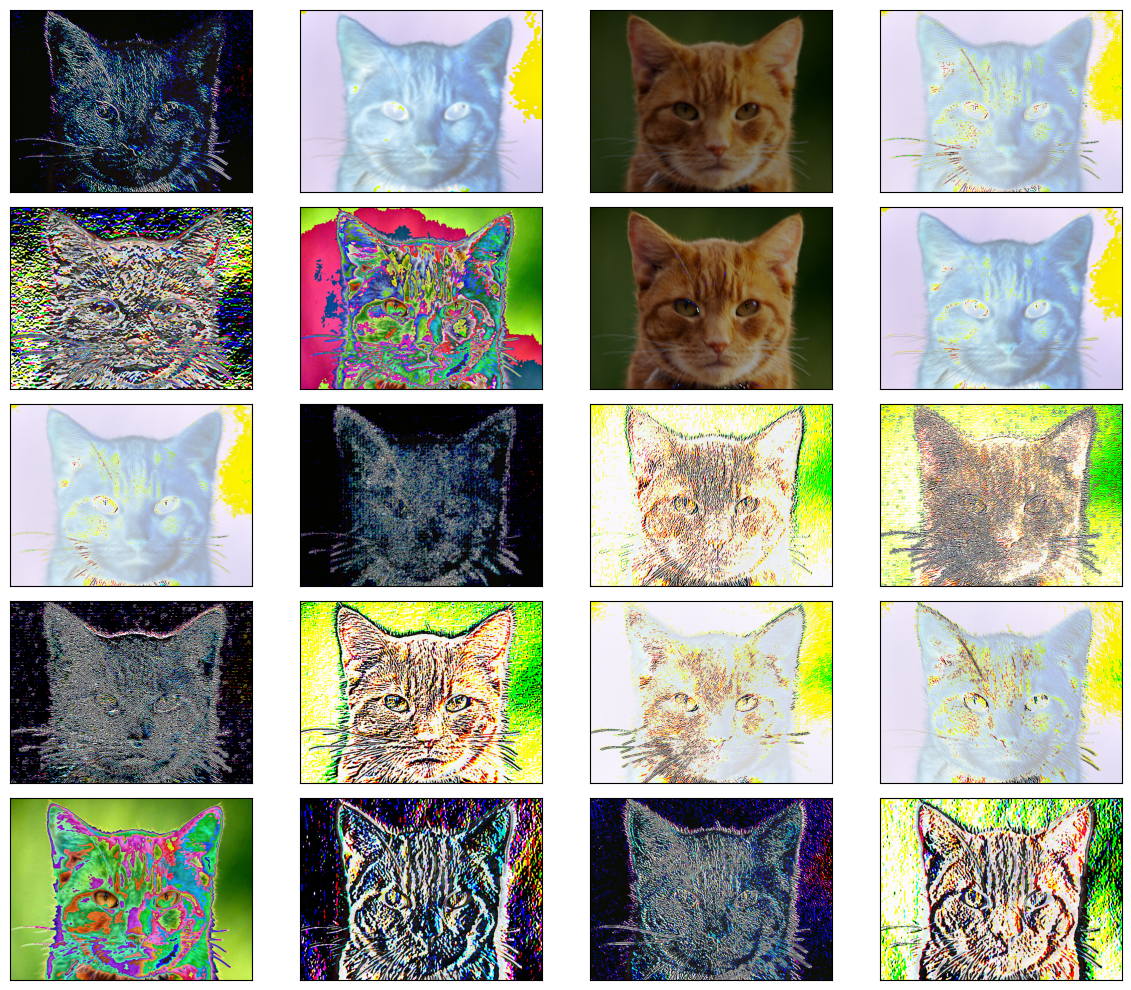

In [50]:
plot_convolutions(cat_image, kernels[::3][:20], ncols = 4, nrows = 5, figsize_ver = 10, single_channel = False)

And here is each kernel convolved with it's respective channel, than the triplets stacked back into color images:

In [51]:
kernel_triplets = []

for unit in range(20):
    kernel_triplets.append([kernel_conv1[:,:, channel, unit].numpy() for channel in range(3)])

len(kernel_triplets), len(kernel_triplets[0]), kernel_triplets[0][0].shape
# I know, I'm a moron when it comes to slicing multiple dimentions

(20, 3, (7, 7))

In [52]:
conv_results = [convolve_color_image_with_3_filters(cat_image, filter_triplet) for filter_triplet in kernel_triplets]

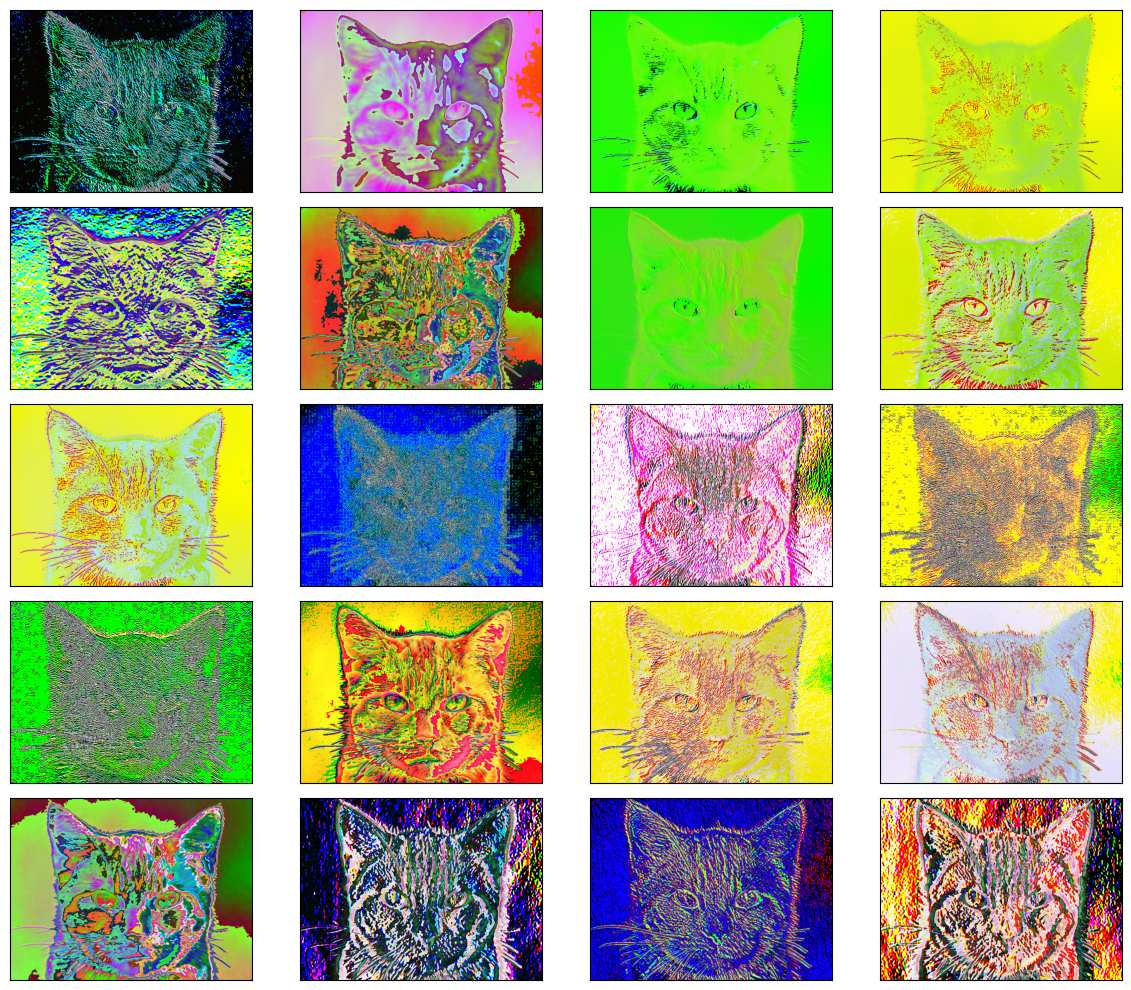

In [53]:
plot_image_subplots(conv_results, ncols = 4, nrows = 5, figsize_ver = 10)

And with these psychedelic cats we conclude our exploration of CNNs.

## On focus - the Conclusion

In the end we want to state that images are really cool and not that hard, convolutions are even cooler and just a bit harder. Diving into the math behind computer vision was very educational (for me), hope it was not too tiresome (for you). This work has become way more lengthy than originally intended, need to wrap this up this now, so thank you for bearing with me throughput this exploration of __Images and Convolutions__.

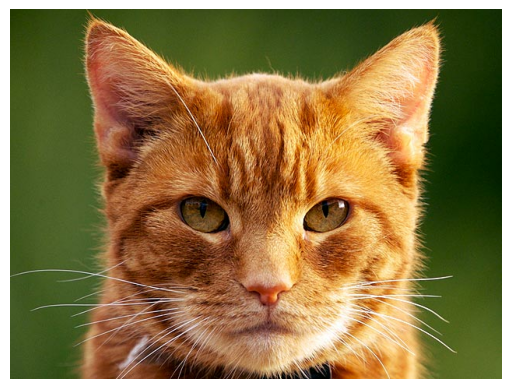

In [54]:
# meow
plt.imshow(cat_image)
plt.axis("off")
plt.show()